# kNN in Python

## Przygotowanie danych i środowiska

In [18]:
import pandas as pd
import numpy as np
import pickle
import statsmodels.api as sm
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn-ticks')
%matplotlib inline

Korzystamy z pliku ```bank-balanced.csv```

In [2]:
df_o = pd.read_csv("data/bank-balanced.csv")
print(df_o.shape)
df_o

(11162, 17)


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11157,33,blue-collar,single,primary,no,1,yes,no,cellular,20,apr,257,1,-1,0,unknown,no
11158,39,services,married,secondary,no,733,no,no,unknown,16,jun,83,4,-1,0,unknown,no
11159,32,technician,single,secondary,no,29,no,no,cellular,19,aug,156,2,-1,0,unknown,no
11160,43,technician,married,secondary,no,0,no,yes,cellular,8,may,9,2,172,5,failure,no


In [5]:
df_o.columns

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'deposit'],
      dtype='object')

In [7]:
target = "deposit"

In [8]:
numFeatures = ['age', 'balance', 'duration', 'campaign', 'pdays','previous', 'day']

In [9]:
catFeatures = [ 'job', 'marital', 'education', 'default',  'housing', 'loan', 'contact',  'month', 'poutcome']

In [10]:
# One hot encoding
dummLev = pd.get_dummies(df_o[catFeatures], drop_first=True)

# Połączenie zmiennych numerycznych, kategorycznych w postaci on hot encoding oraz targetu
df = pd.concat([df_o[numFeatures], dummLev, df_o[[target]]], axis=1)

In [11]:
df.shape

(11162, 43)

In [12]:
df.columns

Index(['age', 'balance', 'duration', 'campaign', 'pdays', 'previous', 'day',
       'job_blue-collar', 'job_entrepreneur', 'job_housemaid',
       'job_management', 'job_retired', 'job_self-employed', 'job_services',
       'job_student', 'job_technician', 'job_unemployed', 'job_unknown',
       'marital_married', 'marital_single', 'education_secondary',
       'education_tertiary', 'education_unknown', 'default_yes', 'housing_yes',
       'loan_yes', 'contact_telephone', 'contact_unknown', 'month_aug',
       'month_dec', 'month_feb', 'month_jan', 'month_jul', 'month_jun',
       'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep',
       'poutcome_other', 'poutcome_success', 'poutcome_unknown', 'deposit'],
      dtype='object')

In [13]:
df[target].value_counts()

no     5873
yes    5289
Name: deposit, dtype: int64

In [14]:
df[numFeatures] = df[numFeatures].apply(lambda x: (x-x.mean())/x.std())

In [15]:
features = df.columns.tolist()
features.remove(target)
print(features)

['age', 'balance', 'duration', 'campaign', 'pdays', 'previous', 'day', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'job_unknown', 'marital_married', 'marital_single', 'education_secondary', 'education_tertiary', 'education_unknown', 'default_yes', 'housing_yes', 'loan_yes', 'contact_telephone', 'contact_unknown', 'month_aug', 'month_dec', 'month_feb', 'month_jan', 'month_jul', 'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep', 'poutcome_other', 'poutcome_success', 'poutcome_unknown']


In [17]:
correlation_matrix = df.corr()
correlation_matrix

,age,balance,duration,campaign,pdays,previous,day,job_blue-collar,job_entrepreneur,job_housemaid,...,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_other,poutcome_success,poutcome_unknown
age,1.000000,0.112300,0.000189,-0.005278,0.002774,0.020169,-0.000762,-0.066567,0.024176,0.082739,...,-0.003606,0.009046,0.029346,-0.122287,0.020910,0.067004,0.040306,-0.018715,0.062114,-0.027021
balance,0.112300,1.000000,0.022436,-0.013894,0.017411,0.030805,0.010467,-0.046220,0.005039,-0.007987,...,-0.057409,0.007900,0.029131,-0.060661,0.077362,0.030111,0.021383,0.028521,0.045603,-0.046091
duration,0.000189,0.022436,1.000000,-0.041557,-0.027392,-0.026716,-0.018511,0.029986,-0.000908,-0.010807,...,0.053493,-0.007325,-0.036984,0.010680,-0.007683,-0.013847,-0.010389,-0.008782,-0.022578,0.044006
campaign,-0.005278,-0.013894,-0.041557,1.000000,-0.102726,-0.049699,0.137007,0.005522,0.013883,0.010570,...,0.114413,0.044453,-0.029530,-0.038520,-0.077215,-0.069786,-0.049224,-0.023689,-0.091807,0.131392
pdays,0.002774,0.017411,-0.027392,-0.102726,1.000000,0.507272,-0.077232,-0.030695,-0.029732,-0.025950,...,-0.099486,-0.094826,0.021950,0.026120,-0.011859,0.074312,0.104793,0.341404,0.329567,-0.823928
previous,0.020169,0.030805,-0.026716,-0.049699,0.507272,1.000000,-0.058981,-0.039939,-0.022470,-0.022766,...,-0.081111,-0.050000,0.028498,-0.025009,0.016852,0.055771,0.092765,0.326587,0.325477,-0.622149
day,-0.000762,0.010467,-0.018511,0.137007,-0.077232,-0.058981,1.000000,-0.023039,-0.004463,0.013318,...,0.129350,-0.181728,-0.041973,-0.010188,0.062185,0.079939,-0.072279,-0.007526,-0.044280,0.082807
job_blue-collar,-0.066567,-0.046220,0.029986,0.005522,-0.030695,-0.039939,-0.023039,1.000000,-0.079905,-0.072850,...,0.002289,0.034933,-0.057910,0.170171,-0.029079,-0.054247,-0.047577,-0.002788,-0.077422,0.066703
job_entrepreneur,0.024176,0.005039,-0.000908,0.013883,-0.029732,-0.022470,-0.004463,-0.079905,1.000000,-0.027602,...,0.036424,0.022241,-0.020873,-0.017064,0.052053,-0.018787,-0.007558,-0.024244,-0.035072,0.036967
job_housemaid,0.082739,-0.007987,-0.010807,0.010570,-0.025950,-0.022766,0.013318,-0.072850,-0.027602,1.000000,...,0.025084,0.042653,0.000838,-0.051037,-0.006554,0.007477,-0.006361,-0.011314,-0.008434,0.023429


In [ ]:
sns.set(rc={'figure.figsize':(10,8)}) # okrślenie rozmiaru rysunku
color_map = sns.diverging_palette(240, 10, n=10) # wybór mapy kolorów
mask = np.triu(np.ones_like(correlation_matrix), k=0) # maska - ukrycie górnej macierzy trójkątnej
sns.heatmap(correlation_matrix,vmin=-1.,vmax=1.,cmap=color_map,mask=mask,square=True) # wykonanie wykresu

Zamieniamy estymator na kNN ```clf = neighbors.KNeighborsClassifier()```
* usunąć samplowanie - korzystając z kNN nie napotkamy na problem wydajnościowe przy tym zbiorze.
Wszystkie pozostałe elementy funkcji pozostaną bez zmian.

## Walidacja pierwszego modelu

In [13]:
# Wczytanie potrzebnych bibliotek
from sklearn.model_selection import KFold
from sklearn import metrics
from sklearn import neighbors
from sklearn.metrics import roc_auc_score

# Przygotujmy wrapper
def CVTestKNN(nFolds = 5, randomState=2020, debug=False, *args, **kwargs):
    kf = KFold(n_splits=nFolds, shuffle=True, random_state=randomState)

    # Listy z wynikami
    testResults = []
    trainResults = []
    predictions = []
    indices = []
    
    # Pętla walidująca model na kolejnych foldach
    for train, test in kf.split(df.index.values):
        # Przygotowanie estymatora
        clf = neighbors.KNeighborsClassifier(*args, **kwargs)
        if debug:
            print(clf)
        # Trenowanie modelu
        clf.fit(df.iloc[train][features], df.iloc[train][target])

        # Przygotowanie prognoz dla zbioru treningowego i testowego
        # UWAGA Sklearn zwracał będzie dwie kolumny prawdopodobieństw dla obydwu klas
        predsTrain = clf.predict_proba(df.iloc[train][features])[:,1]
        preds = clf.predict_proba(df.iloc[test][features])[:,1]
        
        # Zachowajmy informacje o predykcjach dla tego foldu
        predictions.append(preds.tolist().copy())
        
        # Razem z indeksami w oryginalnym data frame
        indices.append(df.iloc[test].index.tolist().copy())
        
        # Policzenie ROC-AUC dla foldów
        trainScore = roc_auc_score((df[target].iloc[train]=="yes").astype(int), predsTrain)
        testScore = roc_auc_score((df[target].iloc[test]=="yes").astype(int), preds)
        
        # Zapisanie wyników dla foldów
        trainResults.append(trainScore)
        testResults.append(testScore)
        
        # Informowanie o każdym foldzie razem z wynikami treningowymi możemy opcjonalnie wyświetlać w trakcie
        if debug:
            print("Train AUC:", trainScore,
                  "Valid AUC:", testScore)
        
    return trainResults, testResults, predictions, indices

W ramach pierwszego testowego uruchomienia sprawdzamy, jak zachowa się algorytm, kiedy jako metrykę użyjemy dystansu minkowskiego z parametrem `p=2`, co oznacza ustawienie z odległościami euklidesowymi. Konfigurując `n_jobs=-1`, użyjemy wszystkich rdzeni, co pozwoli na relatywnie szybkie uzyskanie wyników. Wybieramy na początek 50 najbliższych sąsiadów `n=50`.

In [14]:
trainResults, testResults, predictions, indices = CVTestKNN(n_neighbors=50, n_jobs=-1, p=2, debug=True)
print(np.mean(testResults))

KNeighborsClassifier(n_jobs=-1, n_neighbors=50)
Train AUC: 0.9045826243324572 Valid AUC: 0.8905143617354587
KNeighborsClassifier(n_jobs=-1, n_neighbors=50)
Train AUC: 0.9033008193272006 Valid AUC: 0.9035597392540502
KNeighborsClassifier(n_jobs=-1, n_neighbors=50)
Train AUC: 0.9040898278908048 Valid AUC: 0.9030770813458273
KNeighborsClassifier(n_jobs=-1, n_neighbors=50)
Train AUC: 0.906312343584106 Valid AUC: 0.8859970816492555
KNeighborsClassifier(n_jobs=-1, n_neighbors=50)
Train AUC: 0.9046872309732191 Valid AUC: 0.8958184727108597
0.8957933473390902


##  Tuning hiperparametrów kNN

### Wybór odpowiedniego k
Pierwszym krokiem jest wybranie odpowiedniej liczby najbliższych sąsiadów. Im lepszy wynik, tym najprawdopodobniej najbardziej odpowiednia liczba k.

In [15]:
# Pętla przechodzi po wartościach k i dla każdej wykonuje walidację krzyżową.
for k in [1, 3, 5, 10, 15, 30, 50, 100, 150, 200]:
    trainResults, testResults, predictions, indices = CVTestKNN(n_neighbors=k, n_jobs=-1, p=2)
    print(k, np.mean(trainResults), np.mean(testResults))

1 1.0 0.7663410479801674
3 0.9597073023889194 0.8546275826327367
5 0.945077065616417 0.8759340060184474
10 0.9301933871166439 0.8936315458424383
15 0.9232898131592077 0.8975876008542398
30 0.9121915197982686 0.8983407911540399
50 0.9045945692215576 0.8957933473390902
100 0.8956450604240113 0.8914906205604227
150 0.8902733487447094 0.8870840393800027
200 0.8867061836713969 0.8846206971076851


Wartości w okolicach 30 wydają się być najlepsze. W celu upewnienia się robimy drugi przebieg, który pozwoli na dokładniejsze przeszukanie przestrzeni w okolicach tej wartości.

In [16]:
for k in [15, 20, 25, 30, 35, 40, 45, 50]:
    trainResults, testResults, predictions, indices = CVTestKNN(n_neighbors=k, n_jobs=-1, p=2)
    print(k, np.mean(trainResults), np.mean(testResults))

15 0.9232898131592077 0.8975876008542398
20 0.91811298318201 0.8985247460809669
25 0.9147338978408394 0.8990054889914939
30 0.9121915197982686 0.8983407911540399
35 0.909944993732446 0.89817190455197
40 0.9079441395652555 0.8978185172459117
45 0.906197875631795 0.8967546630418333
50 0.9045945692215576 0.8957933473390902


### Wybór miary dystansu
Sprawdzamy, czy miara Manhattan nie da lepszych efektów. Ponieważ wraz ze zmianą miary może się okazać, że inna liczba sąsiadów daje najlepsze wyniki, ponownie przeszukujemy okolice 30.

In [17]:
for k in [15, 20, 25, 30, 35, 40, 45, 50]:
    trainResults, testResults, predictions, indices = CVTestKNN(n_neighbors=k, n_jobs=-1, p=1)
    print(k, np.mean(testResults))

15 0.8985928344719116
20 0.9004091004551764
25 0.9005479857682698
30 0.9007760991027002
35 0.9005778119506556
40 0.9003527405564352
45 0.8998325029516504
50 0.8996524189644012


##  Feature engineering

### Feature selection
Zmieniamy tylko jedną linię:

```def CVTestKNN(nFolds = 5, randomState=2020, debug=False, features=features, *args, **kwargs):```

In [51]:
from sklearn.model_selection import KFold
from sklearn import metrics
from sklearn import neighbors
from sklearn.metrics import roc_auc_score

# Przygotujmy wrapper
def CVTestKNN(nFolds = 5, randomState=2020, debug=False, features=features, *args, **kwargs):
    kf = KFold(n_splits=nFolds, shuffle=True, random_state=randomState)

    # Listy z wynikami
    testResults = []
    trainResults = []
    predictions = []
    indices = []
    
    for train, test in kf.split(df.index.values):
        # Przygotowanie estymatora
        clf = neighbors.KNeighborsClassifier(*args, **kwargs)
        if debug:
            print(clf)
        # Trenowanie modelu
        clf.fit(df.iloc[train][features], df.iloc[train][target])

        # Przygotowanie prognoz dla zbioru traeningowego i testowego
        # UWAGA Sklearn zwracałbędzie dwie kolumny prawdopodobieństw dla obydwu klas
        predsTrain = clf.predict_proba(df.iloc[train][features])[:,1]
        preds = clf.predict_proba(df.iloc[test][features])[:,1]
        
        # Zachowajmy informacje o predykcjach dla tego foldu
        predictions.append(preds.tolist().copy())
        
        # Razem z indeksami w oryginalnym data frame
        indices.append(df.iloc[test].index.tolist().copy())
        
        # Policzenie ROC-AUC dla foldów
        trainScore = roc_auc_score((df[target].iloc[train]=="yes").astype(int), predsTrain)
        testScore = roc_auc_score((df[target].iloc[test]=="yes").astype(int), preds)
        
        # Zapisanie wyników dla foldów
        trainResults.append(trainScore)
        testResults.append(testScore)
        
        # Informowanie o każdym foldzie razem z wynikami treningowymi możemy opcjonalnie wyświetlać w trakcie
        if debug:
            print("Train AUC:", trainScore,
                  "Valid AUC:", te|stScore)
        
    return trainResults, testResults, predictions, indices


Wrapper do walidacji poszczególnych zmiennych. Estymujemy model dla każdej zmiennej pojedynczo.

In [19]:
# Następnie dodajemy każdą zmienną jako osobnego kandydata.
results = []
for feature in features:
    # Estymacja modelu
    trainResults, testResults, predictions, indices = CVTestKNN(n_neighbors=30, n_jobs=-1, p=1, features=[feature])
    print(feature, np.mean(testResults))
    # Zapisanie wyniku jako do obiektu results
    results.append((feature, np.mean(testResults)))

age 0.5698982759626874
balance 0.5458335965140438
duration 0.7932697774613371
campaign 0.5440797070369292
pdays 0.42850327384990905
previous 0.39981262256304306
day 0.5617319272129111
job_blue-collar 0.5382697862499052
job_entrepreneur 0.5058805697812687
job_housemaid 0.5037228656015285
job_management 0.484706395399438
job_retired 0.47357874831773633
job_self-employed 0.5008453617690051
job_services 0.5122976715796377
job_student 0.48232937931033115
job_technician 0.5042431002430413
job_unemployed 0.4941046508812027
job_unknown 0.4998614528023014
marital_married 0.49097022233506216
marital_single 0.4559648806342074
education_secondary 0.5259145421236813
education_tertiary 0.45548532946274856
education_unknown 0.49702140633571795
default_yes 0.5049684031919591
housing_yes 0.6018682588594751
loan_yes 0.537269717016656
contact_telephone 0.4958159864813987
contact_unknown 0.6044786447638495
month_aug 0.505721026986041
month_dec 0.4986250749747786
month_feb 0.4868372214683913
month_jan 0.50

Sortujemy listę `results` po drugiej wartości (`np.mean(testResults)`).

In [20]:
results = sorted(results, key=lambda x: x[1], reverse=True)
results

[('duration', 0.7932697774613371),
 ('contact_unknown', 0.6044786447638495),
 ('housing_yes', 0.6018682588594751),
 ('month_may', 0.5741445504709087),
 ('age', 0.5698982759626874),
 ('day', 0.5617319272129111),
 ('balance', 0.5458335965140438),
 ('campaign', 0.5440797070369292),
 ('job_blue-collar', 0.5382697862499052),
 ('loan_yes', 0.537269717016656),
 ('education_secondary', 0.5259145421236813),
 ('month_jul', 0.5162393591820085),
 ('job_services', 0.5122976715796377),
 ('month_nov', 0.507849244866879),
 ('month_jun', 0.5059998115353872),
 ('job_entrepreneur', 0.5058805697812687),
 ('month_aug', 0.505721026986041),
 ('default_yes', 0.5049684031919591),
 ('job_technician', 0.5042431002430413),
 ('month_jan', 0.5037919372595943),
 ('job_housemaid', 0.5037228656015285),
 ('job_self-employed', 0.5008453617690051),
 ('job_unknown', 0.4998614528023014),
 ('month_dec', 0.4986250749747786),
 ('education_unknown', 0.49702140633571795),
 ('contact_telephone', 0.4958159864813987),
 ('job_unemp

Zmienna `duration` jest zdecydowanie na pierwszym miejscu. Ponieważ procedura była czasochłonna, sprawdzamy, co się stanie, jeżeli po prostu weźmiemy wszystkie zmienne, dla których uzyskany wynik był > 0.5.

In [21]:
featuresSet2 = [x for x,y in results if y > 0.5]
print(featuresSet2)

['duration', 'contact_unknown', 'housing_yes', 'month_may', 'age', 'day', 'balance', 'campaign', 'job_blue-collar', 'loan_yes', 'education_secondary', 'month_jul', 'job_services', 'month_nov', 'month_jun', 'job_entrepreneur', 'month_aug', 'default_yes', 'job_technician', 'month_jan', 'job_housemaid', 'job_self-employed']


Wykonujemy model dla tego wariantu:

In [22]:
trainResults, testResults, predictions, indices = CVTestKNN(n_neighbors=30, n_jobs=-1, p=1, features=featuresSet2)
print(np.mean(testResults))

0.8937517600494344


Wyniki nie są rewelacyjne. Usuwamy wyłącznie nagorszą zmienną (wybierając parametr > 0.4).

In [23]:
featuresSet3 = [x for x,y in results if y > 0.4]
print(featuresSet3)

['duration', 'contact_unknown', 'housing_yes', 'month_may', 'age', 'day', 'balance', 'campaign', 'job_blue-collar', 'loan_yes', 'education_secondary', 'month_jul', 'job_services', 'month_nov', 'month_jun', 'job_entrepreneur', 'month_aug', 'default_yes', 'job_technician', 'month_jan', 'job_housemaid', 'job_self-employed', 'job_unknown', 'month_dec', 'education_unknown', 'contact_telephone', 'job_unemployed', 'marital_married', 'poutcome_other', 'month_feb', 'job_management', 'job_student', 'month_oct', 'month_mar', 'month_sep', 'job_retired', 'poutcome_success', 'marital_single', 'education_tertiary', 'poutcome_unknown', 'pdays']


Walidacja otrzymanego modelu w wariancie bez jednej zmiennej (wybierając parametr > 0.43):

In [24]:
trainResults, testResults, predictions, indices = CVTestKNN(n_neighbors=30, n_jobs=-1, p=1, features=featuresSet3)
print(np.mean(testResults))

0.9016725110831129


Walidacja modelu w wariancie bez dwóch zmiennych:

In [28]:
featuresSet4 = [x for x,y in results if y > 0.43]
print(featuresSet4)
trainResults, testResults, predictions, indices = CVTestKNN(n_neighbors=30, n_jobs=-1, p=1, features=featuresSet4)
print(np.mean(testResults))

['duration', 'contact_unknown', 'housing_yes', 'month_may', 'age', 'day', 'balance', 'campaign', 'job_blue-collar', 'loan_yes', 'education_secondary', 'month_jul', 'job_services', 'month_nov', 'month_jun', 'job_entrepreneur', 'month_aug', 'default_yes', 'job_technician', 'month_jan', 'job_housemaid', 'job_self-employed', 'job_unknown', 'month_dec', 'education_unknown', 'contact_telephone', 'job_unemployed', 'marital_married', 'poutcome_other', 'month_feb', 'job_management', 'job_student', 'month_oct', 'month_mar', 'month_sep', 'job_retired', 'poutcome_success', 'marital_single', 'education_tertiary', 'poutcome_unknown']
0.901912823168398


Niewielka poprawa. 

### Feature generation
Sprawdzamy, jak zachowa się algorytm, jeżeli dla poszczególnych zmiennych zmieniać będziemy skalę. Dla każdej ze zmiennych dwukrotnie zwiększamy ich skalę relatywnie do pozostałych zmiennych.

In [29]:
# Kopia zapasową zbioru.
dfCopy = df.copy()

In [30]:
# Dodajemy każdą zmienną jako kandydata.
results2 = []
for feature in featuresSet4:
    df = dfCopy.copy()
    # Dwukrotnie zwiększamy zmienną
    df[feature]=df[feature]*2
#     Walidujemy model
    trainResults, testResults, predictions, indices = CVTestKNN(n_neighbors=30, n_jobs=-1, p=1, features=featuresSet4)
    print(feature, np.mean(testResults))
    results2.append((feature, np.mean(testResults)))

duration 0.9111074134332174
contact_unknown 0.9008669621453922
housing_yes 0.897692048516116
month_may 0.9027719270862888
age 0.8981739417220158
day 0.9022690465618453
balance 0.9003871151353
campaign 0.8985194110363937
job_blue-collar 0.8993244354307013
loan_yes 0.9007192804416789
education_secondary 0.8998901577570292
month_jul 0.9030802927133958
job_services 0.8998981335552891
month_nov 0.9027461396989489
month_jun 0.9020177994111818
job_entrepreneur 0.9012788924420022
month_aug 0.9010830210954481
default_yes 0.9018285410079635
job_technician 0.8996589307107383
month_jan 0.903031987342722
job_housemaid 0.9014758374324983
job_self-employed 0.9017720059550477
job_unknown 0.9017938740887683
month_dec 0.9020460079250862
education_unknown 0.901629671506943
contact_telephone 0.9017103567157557
job_unemployed 0.9013551045969675
marital_married 0.9002090829276655
poutcome_other 0.9014100705801089
month_feb 0.9024422823393697
job_management 0.900165096150207
job_student 0.9011086436053686
mo

In [31]:
# Sortowanie wyników
results2 = sorted(results2, key=lambda x: x[1], reverse=True)
results2

[('duration', 0.9111074134332174),
 ('month_jul', 0.9030802927133958),
 ('month_jan', 0.903031987342722),
 ('month_may', 0.9027719270862888),
 ('month_nov', 0.9027461396989489),
 ('month_mar', 0.9025116483017708),
 ('month_feb', 0.9024422823393697),
 ('day', 0.9022690465618453),
 ('month_oct', 0.9022247947254023),
 ('month_dec', 0.9020460079250862),
 ('month_jun', 0.9020177994111818),
 ('default_yes', 0.9018285410079635),
 ('month_sep', 0.9018042982173202),
 ('job_unknown', 0.9017938740887683),
 ('job_self-employed', 0.9017720059550477),
 ('contact_telephone', 0.9017103567157557),
 ('education_unknown', 0.901629671506943),
 ('poutcome_unknown', 0.9015105442359304),
 ('job_housemaid', 0.9014758374324983),
 ('poutcome_other', 0.9014100705801089),
 ('job_unemployed', 0.9013551045969675),
 ('job_entrepreneur', 0.9012788924420022),
 ('job_student', 0.9011086436053686),
 ('month_aug', 0.9010830210954481),
 ('poutcome_success', 0.9009806697091236),
 ('contact_unknown', 0.9008669621453922),
 (

Wyszło, że większanie rozpiętości `duration` było pomocne. Jednocześnie zwiększanie niektórych innych zmiennych było wręcz szkodliwe. Przetestujemy różne zakresy skalowania dla najlepszej i dwóch najgorszych zmiennych.

In [32]:
df["duration"]

0        1.930139
1        3.154470
2        2.929770
3        0.596339
4        0.867132
           ...   
11157   -0.331272
11158   -0.832527
11159   -0.622230
11160   -1.045705
11161    0.737497
Name: duration, Length: 11162, dtype: float64

In [33]:
for k in [1.5, 2, 3, 4, 5]:
    df = dfCopy.copy()
    #-k krotnie zwiększamy zmienną
    df["duration"]=df["duration"]*k
    trainResults, testResults, predictions, indices = CVTestKNN(n_neighbors=30, n_jobs=-1, p=1, features=featuresSet4)
    print(k, np.mean(testResults))

1.5 0.9085484315802361
2 0.9111074134332174
3 0.9126474339534486
4 0.9124483668424181
5 0.9119143523369649


In [34]:
for k in [0.1, 0.25, 0.4, 0.5, 0.65,  0.8]:
    df = dfCopy.copy()
    
    # Dla dotychczas najlepszej wartości k dla duration ustalamy mnożnik i szukamy dla kolejnej zmiennej
    df["duration"]=df["duration"]*3
    
    # k-krotnie zwiększamy zmienną
    df["housing_yes"]=df["housing_yes"]*k
    trainResults, testResults, predictions, indices = CVTestKNN(n_neighbors=30, n_jobs=-1, p=1, features=featuresSet4)
    print(k, np.mean(testResults))

0.1 0.9109401078414079
0.25 0.9116977427506427
0.4 0.9124484240430247
0.5 0.912825115288064
0.65 0.9129018825374626
0.8 0.9129491025242341


In [48]:
for k in [0.1, 0.25, 0.4, 0.5, 0.65,  0.8]:
    df = dfCopy.copy()
    
    # Wykorzystujemy wcześniej zdobytą wiedzę
    df["duration"]=df["duration"]*3
    df["housing_yes"]=df["housing_yes"]*0.8
    
    # k krotnie zwiększamy zmienną
    df["age"]=df["age"]*k
    trainResults, testResults, predictions, indices = CVTestKNN(n_neighbors=30, n_jobs=-1, p=1, features=featuresSet4)
    wyniki.append((k, np.mean(testResults)))
    print(k, np.mean(testResults))

0.1 0.9134322485476962
0.25 0.9131960800422878
0.4 0.9134762593027625
0.5 0.9134963403085962
0.65 0.9134048646396021
0.8 0.9134525077902751


Jak widać stopniowo, iteracyjnie udaje nam się lekko poprawiać wyniki. Na teraz uznamy taką specyfikację modelu za "najlepszą".

In [46]:
df = dfCopy.copy()

# Wykorzystujemy wcześniej zdobytą wiedzę
df["duration"]=df["duration"]*3
df["housing_yes"]=df["housing_yes"]*0.8
df["age"]=df["age"]*0.4
trainResults, testResults, predictions, indices = CVTestKNN(n_neighbors=30, n_jobs=-1, p=1, features=featuresSet4)
print("k: ", k, "\nnp.mean(testResults): ", np.mean(testResults))

modelkNN = {
    "name":"KNN",
    "description":"Pierwszy dopracowany model KNN, 30 sąsiadów, i ograniczona liczba zmodyfkowanych zmiennych",
    "specification":'n_neighbors=30, n_jobs=-1, p=1, features=featuresSet4',
    "trainResults":trainResults.copy(),
    "testResults":testResults.copy(),
    "predictions":predictions.copy(),
    "indices":indices.copy(),
}

k:  0.8 
np.mean(testResults):  0.9134762593027625


In [50]:
# modelkNN

In [41]:
from sklearn.metrics import roc_curve, roc_auc_score

def plotROCs(results):
    ''' Funkcja, do rysowania szeregu wyników krzywych ROC dla poszczególnych eksperymentów
    results - lista wyników jako 3 elementowe tuple (true, pred, label)
    '''
    
    # Ustalanie wielkości rysunku
    fig, ax = plt.subplots(figsize=(10,9))
        
    for true, pred, label in results:
        # Obliczenie punktów potrzebnych do narysowani akrzywej ROC
        # funkcja roc_curve zwarca trzy serie danych, fpr, tpr oraz poziomy progów odcięcia
        fpr, tpr, thresholds = roc_curve(true, pred)
        # Obliczamy pole powierzchni pod krzywą
        rocScore = roc_auc_score(true, pred)
        rocScore = round(rocScore, 3)
        # Rysujemy krzywą ROC
        ax.plot(fpr, tpr, lw=2, label=f'{label}: {rocScore}')
        
    # Rysujemy krzywą 45 stopni jako punkt odniesienia
    ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    # Dodajemy lekkie marginesy do zakresu aby krzywa nie pokrywała się z osiami
    ax.set_xlim([-0.01, 1.0])
    ax.set_ylim([0.0, 1.01])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'Receiver operating characteristic - {rocScore}')
    ax.legend(loc="lower right")
    plt.show()

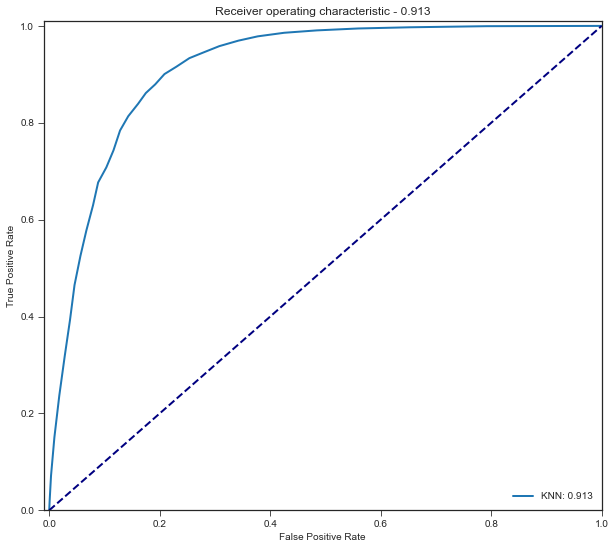

In [42]:
res2plot = []
true = (df[target]=="yes").astype(int).sort_index()
for result in [modelkNN]:
    # Tworzymy wektor predykcji tworząc serię pandasa, a następnie sortujemy indeks
    pred = pd.Series(sum(result["predictions"], []), index=sum(result["indices"], [])).sort_index()
    res2plot.append((true, pred, result["name"]))
    
# Wywołujemy funkcję do rysowania
plotROCs(res2plot)

In [47]:
res2plot

[(0        1
  1        1
  2        1
  3        1
  4        1
          ..
  11157    0
  11158    0
  11159    0
  11160    0
  11161    0
  Name: deposit, Length: 11162, dtype: int32,
  0        0.900000
  1        0.833333
  2        0.866667
  3        0.366667
  4        0.533333
             ...   
  11157    0.100000
  11158    0.000000
  11159    0.133333
  11160    0.033333
  11161    0.733333
  Length: 11162, dtype: float64,
  'KNN')]